In [116]:
from matplotlib import pyplot as plt
from matplotlib.image import imread
import numpy as np
import os

In [117]:
from google.colab import drive
drive.mount('/content/drive')

TRAIN_IMG_FOLDER = 'drive/MyDrive/Colab Notebooks/Training images/'
TEST_IMG_FOLDER = 'drive/MyDrive/Colab Notebooks/Test/'

train_set_files = os.listdir(TRAIN_IMG_FOLDER)
test_set_files = os.listdir(TEST_IMG_FOLDER)

width  = 128
height = 128

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
train_id_file = set([f.split('_')[0] for f in train_set_files])
test_id_file = set([f.split('_')[0] for f in train_set_files])
print(train_id_file <= test_id_file)

True


Train Images:


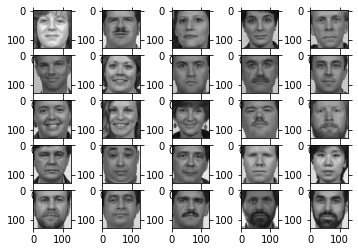

Test Images:


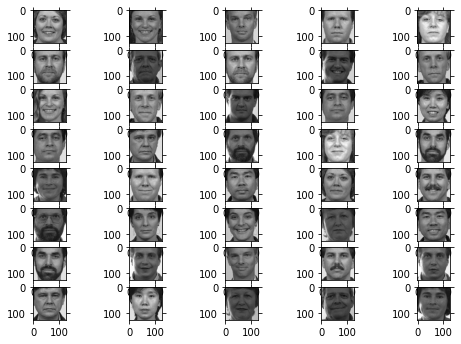

In [119]:
print('Train Images:')
train_image_names = os.listdir(TRAIN_IMG_FOLDER)
training_tensor   = np.ndarray(shape=(len(train_image_names), height*width), dtype=np.float64)

for i in range(len(train_image_names)):
    img = plt.imread(TRAIN_IMG_FOLDER + train_image_names[i])
    training_tensor[i,:] = np.array(img, dtype='float64').flatten()
    plt.subplot(5,5,i+1)
    plt.imshow(img, cmap='gray')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

print('Test Images:')
test_image_names = os.listdir(TEST_IMG_FOLDER)#[i for i in dataset_dir if i not in train_image_names]
testing_tensor   = np.ndarray(shape=(len(test_image_names), height*width), dtype=np.float64)

for i in range(len(test_image_names)):
    img = imread(TEST_IMG_FOLDER + test_image_names[i])
    testing_tensor[i,:] = np.array(img, dtype='float64').flatten()
    plt.subplot(8,5,1+i)
    plt.imshow(img, cmap='gray')
    plt.subplots_adjust(right=1.2, top=1.2)
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

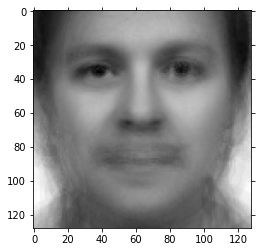

In [120]:
mean_face = np.zeros((1,height*width))

for i in training_tensor:
    mean_face = np.add(mean_face,i)

mean_face = np.divide(mean_face,float(len(train_image_names))).flatten()

plt.imshow(mean_face.reshape(height, width), cmap='gray')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

In [121]:
normalised_training_tensor = np.ndarray(shape=(len(train_image_names), height*width))

for i in range(len(train_image_names)):
    normalised_training_tensor[i] = np.subtract(training_tensor[i],mean_face)

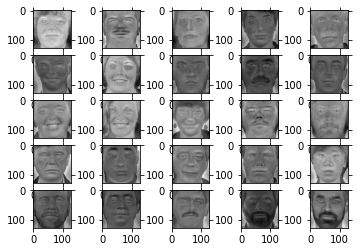

In [122]:
for i in range(len(train_image_names)):
    img = normalised_training_tensor[i].reshape(height,width)
    plt.subplot(5,5,1+i)
    plt.imshow(img, cmap='gray')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

In [123]:
cov_matrix=np.cov(normalised_training_tensor)
cov_matrix = np.divide(cov_matrix,25.0)
print('Covariance Matrix Shape:', cov_matrix.shape)


Covariance Matrix Shape: (25, 25)


In [124]:
#eigenvalues and eigenvectors
eigenvalues, eigenvectors, = np.linalg.eig(cov_matrix)
print('eigenvalues.shape: {} eigenvectors.shape: {}'.format(eigenvalues.shape, eigenvectors.shape))

eigenvalues.shape: (25,) eigenvectors.shape: (25, 25)


In [125]:
eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

# Sort the eigen pairs in descending order:
eig_pairs.sort(reverse=True)
eigvalues_sort  = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]

sorted_ind = sorted(range(eigenvalues.shape[0]), key=lambda k: eigenvalues[k], reverse=True)

eigvalues_sort = eigenvalues[sorted_ind]
eigvectors_sort = eigenvectors[sorted_ind]
train_set_files_sort = np.array(train_set_files)[sorted_ind]

In [126]:
reduced_data = np.array(eigvectors_sort[:25]).transpose()
reduced_data.shape


(25, 25)

In [127]:
print(training_tensor.transpose().shape, reduced_data.shape)


(16384, 25) (25, 25)


In [128]:
proj_data = np.dot(training_tensor.transpose(),reduced_data)
proj_data = proj_data.transpose()
proj_data.shape

(25, 16384)

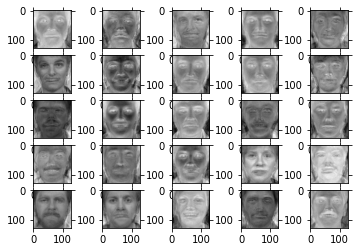

In [129]:
for i in range(proj_data.shape[0]):
    img = proj_data[i].reshape(height,width)
    plt.subplot(5,5,1+i)
    plt.imshow(img, cmap='gray')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

In [130]:
w = np.array([np.dot(proj_data,i) for i in normalised_training_tensor])
print(w.shape)

(25, 25)


In [131]:
def recogniser(test_image_names, train_image_names, proj_data, w, t0=2e8, prn=False):

    count        = 0
    num_images   = 0
    correct_pred = 0
    
    result = []
    wts = []
    
    #False match rate (FMR)
    FMR_count = 0
    
    #False non-match rate (FNMR)
    FNMR_count = 0
     

    test_image_names2 = sorted(test_image_names)

    for img in test_image_names2:

        unknown_face = plt.imread(TEST_IMG_FOLDER+img)
        num_images += 1
        
        unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()
        normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)

        w_unknown = np.dot(proj_data, normalised_uface_vector)
        diff  = w - w_unknown
        norms = np.linalg.norm(diff, axis=1)
        index = np.argmin(norms)
        
        wts.append([count, norms[index]])

        if prn: print('Input:'+'.'.join(img.split('.')[:2]), end='\t')
        count+=1
        
        match = img.split('_')[0] == train_image_names[index].split('_')[0]

        if norms[index] < t0:
            if match:
                if prn:
                  print('Matched: ' + train_image_names[index], end = '\t')
                correct_pred += 1
                result.append(1)
            else:
                if prn:
                  print('F/Matched: '+train_image_names[index], end = '\t')
                result.append(0)
                FMR_count += 1
        else:
            if match:
                if prn: print('F/Unknown face: '+train_image_names[index], end = '\t')
                result.append(0)
                FNMR_count +=1
                
            else:
                if prn: print('Unknown face: '+train_image_names[index], end = '\t')
                result.append(1)
                correct_pred += 1



        if prn: print(norms[index], end=' ')
        if prn: print()
            
            
    
    FMR = FMR_count/num_images
    FNMR = FNMR_count/num_images
    
    
    print('Correct predictions: {}/{} = {:.2f} \t\t'.format(correct_pred, num_images, correct_pred/num_images), end=' ')
    print('FMR: {:.2f} \t'.format(FMR), end=' ')
    print('FNMR: {:.2f} \t'.format(FNMR))
    
    
    
    return wts, result, correct_pred, num_images, FMR, FNMR
    

wts, result, correct_pred, num_images, FMR, FNMR =recogniser(test_image_names, train_image_names,proj_data,w, t0=2e7, prn=True)

Input:00770_960530_fa.jpg	Matched: 00770_960530_fa.jpg	0.0 
Input:00770_960530_fa_a.jpg	Unknown face: 00744_941201_fa.jpg	40443667.46730251 
Input:00771_941205_fa.jpg	Matched: 00771_941205_fa.jpg	0.0 
Input:00771_941205_fb.jpg	Matched: 00771_941205_fa.jpg	12411902.370116843 
Input:00772_941201_fa.jpg	Matched: 00772_941201_fa.jpg	0.0 
Input:00772_941201_fb.jpg	Unknown face: 00763_941201_fa.jpg	21167349.76704065 
Input:00773_941201_fa.jpg	Matched: 00773_941201_fa.jpg	0.0 
Input:00773_941201_fb.jpg	F/Unknown face: 00773_941201_fa.jpg	21385298.89308546 
Input:00775_941205_fa.jpg	Matched: 00775_941205_fa.jpg	0.0 
Input:00775_941205_fb.jpg	Matched: 00775_941205_fa.jpg	9590985.449027335 
Input:00779_941205_fa.jpg	Matched: 00779_941205_fa.jpg	0.0 
Input:00779_941205_fb.jpg	F/Unknown face: 00779_941205_fa.jpg	38922068.40712183 
Input:00781_941205_fa.jpg	Matched: 00781_941205_fa.jpg	0.0 
Input:00781_941205_fb.jpg	F/Matched: 00804_941205_fa.jpg	14277462.667984808 
Input:00787_941205_fa.jpg	Matche

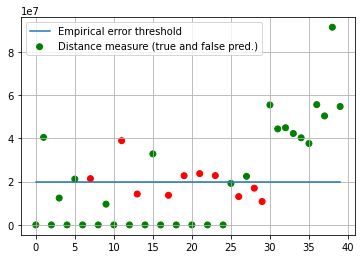

In [132]:
def rg(r):
    if r: return 'g'
    else: return 'r'
cl = [rg(r) for r in result]

x=[x[0] for x in wts]
y=[y[1] for y in wts]
plt.scatter(x,y, color=cl, label = 'Distance measure (true and false pred.)')

x2=[x[0] for x in wts]
y2=[2e7 for y in wts]

plt.plot(x2,y2, label = 'Empirical error threshold')
plt.legend()
plt.grid()

plt.show()

In [133]:
CPR_list, t0_list, FMR_list, FNMR_list = [], [] , [] , []
for t0 in np.linspace(start=0, stop=1e8, num=20):
    print('{:e}'.format(t0), end=' ')
    wts, result, correct_pred, num_images, FMR, FNMR = recogniser(test_image_names, train_image_names,proj_data,w, t0)
    
    CPR_list.append(correct_pred/num_images) 
    t0_list.append(t0)
    FMR_list.append(FMR)
    FNMR_list.append(FNMR)

0.000000e+00 Correct predictions: 19/40 = 0.47 		 FMR: 0.00 	 FNMR: 0.53 	
5.263158e+06 Correct predictions: 32/40 = 0.80 		 FMR: 0.00 	 FNMR: 0.20 	
1.052632e+07 Correct predictions: 33/40 = 0.82 		 FMR: 0.00 	 FNMR: 0.17 	
1.578947e+07 Correct predictions: 30/40 = 0.75 		 FMR: 0.10 	 FNMR: 0.15 	
2.105263e+07 Correct predictions: 30/40 = 0.75 		 FMR: 0.12 	 FNMR: 0.12 	
2.631579e+07 Correct predictions: 32/40 = 0.80 		 FMR: 0.17 	 FNMR: 0.03 	
3.157895e+07 Correct predictions: 32/40 = 0.80 		 FMR: 0.17 	 FNMR: 0.03 	
3.684211e+07 Correct predictions: 31/40 = 0.78 		 FMR: 0.20 	 FNMR: 0.03 	
4.210526e+07 Correct predictions: 29/40 = 0.72 		 FMR: 0.28 	 FNMR: 0.00 	
4.736842e+07 Correct predictions: 26/40 = 0.65 		 FMR: 0.35 	 FNMR: 0.00 	
5.263158e+07 Correct predictions: 25/40 = 0.62 		 FMR: 0.38 	 FNMR: 0.00 	
5.789474e+07 Correct predictions: 22/40 = 0.55 		 FMR: 0.45 	 FNMR: 0.00 	
6.315789e+07 Correct predictions: 22/40 = 0.55 		 FMR: 0.45 	 FNMR: 0.00 	
6.842105e+07 Correct pred

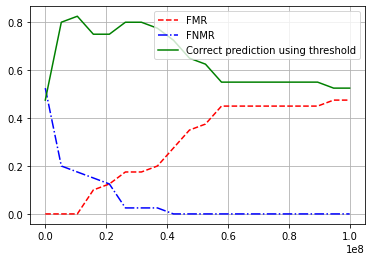

In [134]:
x1=t0_list
y1=FMR_list

x2=t0_list
y2=FNMR_list

x3=t0_list
y3=CPR_list

plt.plot(x1,y1, ls='--', color='r', label='FMR',)
plt.plot(x2,y2, ls='-.', color='b', label='FNMR')
plt.plot(x3,y3, color='g', label='Correct prediction using threshold')

plt.grid()
plt.legend()

30


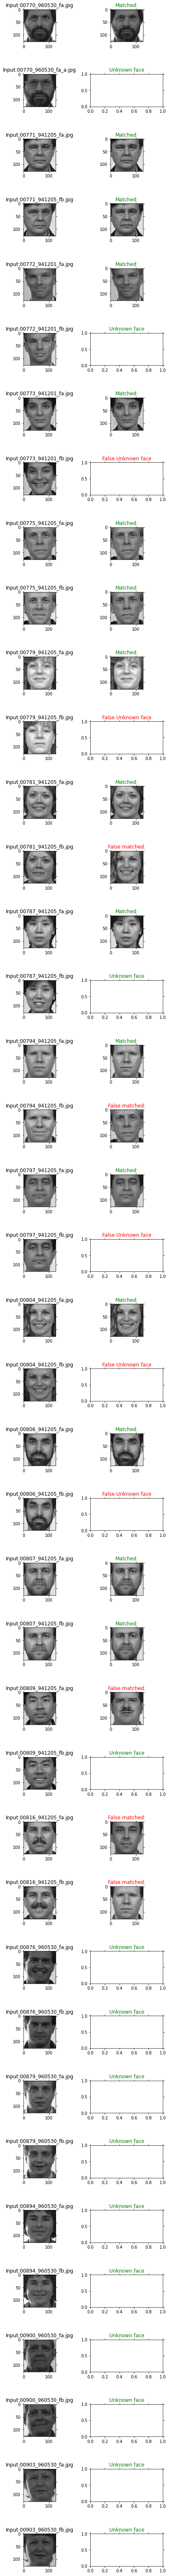

In [135]:
count        = 0
num_images   = 0
correct_pred = 0
def Visualization(img, train_image_names,proj_data,w, t0):
    global count,highest_min,num_images,correct_pred
    unknown_face        = plt.imread(TEST_IMG_FOLDER+img)
    num_images          += 1
    unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()
    normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)
    
    plt.subplot(40,2,1+count)
    plt.imshow(unknown_face, cmap='gray')
    plt.title('Input:'+'.'.join(img.split('.')[:2]))
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    count+=1
    
    w_unknown = np.dot(proj_data, normalised_uface_vector)
    diff  = w - w_unknown
    norms = np.linalg.norm(diff, axis=1)
    index = np.argmin(norms)
    
   

    
    plt.subplot(40,2,1+count)

    match = img.split('_')[0] == train_image_names[index].split('_')[0]

    if norms[index] < t0: 
            
        if match:
            plt.title('Matched:', color='g')
            plt.imshow(imread(TRAIN_IMG_FOLDER+train_image_names[index]), cmap='gray')
                
            correct_pred += 1
        else:
            plt.title('False matched:', color='r')
            plt.imshow(imread(TRAIN_IMG_FOLDER+train_image_names[index]), cmap='gray')
    else:
        if not match:
            plt.title('Unknown face', color='g')
            correct_pred += 1
        else:
            plt.title('False Unknown face', color='r')
                
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    plt.subplots_adjust(right=1.2, top=3 , hspace=1)
   
    count+=1

    
fig = plt.figure(figsize=(5, 30))

test_image_names2 = sorted(test_image_names)
for i in range(len(test_image_names2)):
    Visualization(test_image_names2[i], train_image_names,proj_data,w, t0=2e7)

print(correct_pred)
plt.show()
